Imagen encontrada: OR_ABI-L2-ACMF-M6_G16_s20230701050021.jpg para el timestamp 2023-07-01 05:00:00
Imagen encontrada: OR_ABI-L2-ACMF-M6_G16_s20230701051021.jpg para el timestamp 2023-07-01 05:10:00
Imagen encontrada: OR_ABI-L2-ACMF-M6_G16_s20230701052021.jpg para el timestamp 2023-07-01 05:20:00
Imagen encontrada: OR_ABI-L2-ACMF-M6_G16_s20230701053021.jpg para el timestamp 2023-07-01 05:30:00
Imagen encontrada: OR_ABI-L2-ACMF-M6_G16_s20230701054021.jpg para el timestamp 2023-07-01 05:40:00
Imagen encontrada: OR_ABI-L2-ACMF-M6_G16_s20230701055021.jpg para el timestamp 2023-07-01 05:50:00
Imagen encontrada: OR_ABI-L2-ACMF-M6_G16_s20230701060021.jpg para el timestamp 2023-07-01 06:00:00
Imagen encontrada: OR_ABI-L2-ACMF-M6_G16_s20230701061021.jpg para el timestamp 2023-07-01 06:10:00
Imagen encontrada: OR_ABI-L2-ACMF-M6_G16_s20230701062021.jpg para el timestamp 2023-07-01 06:20:00
Imagen encontrada: OR_ABI-L2-ACMF-M6_G16_s20230701063021.jpg para el timestamp 2023-07-01 06:30:00
Imagen enc

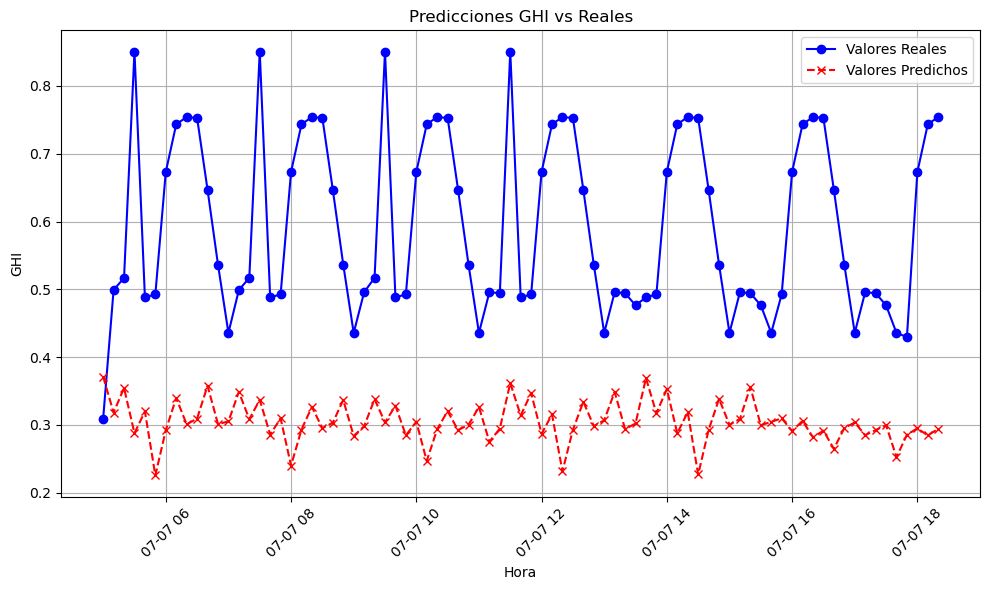

In [16]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime, timedelta
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Concatenate, Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import timedelta
import os
from PIL import Image

# Función para convertir el formato de timestamp al nuevo formato de los nombres de las imágenes
def timestamp_to_image_name(timestamp, mode='M6'):
    return f'OR_ABI-L2-ACMF-{mode}_G16_s' + timestamp.strftime('%Y%m%d%H%M')

# Función para buscar la imagen más cercana si no hay coincidencia exacta
def find_closest_image(timestamp, image_folder, modes=['M6', 'M4'], max_diff_minutes=10):
    for delta in range(-max_diff_minutes, max_diff_minutes + 1):
        adjusted_timestamp = timestamp + timedelta(minutes=delta)
        for mode in modes:
            image_name_base = timestamp_to_image_name(adjusted_timestamp, mode)
            for filename in os.listdir(image_folder):
                if filename.startswith(image_name_base):
                    image_path = os.path.join(image_folder, filename)
                    print(f"Imagen encontrada: {image_path}")
                    return image_path
    return None

# Cargar imágenes y valores GHI normalizados, con imágenes redimensionadas a 64x64
def load_images_and_ghi(df_filtrado, image_folder):
    images = []
    ghi_values = []
    
    image_files = sorted(os.listdir(image_folder))
    
    for index, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        timestamp_formatted = timestamp.strftime('OR_ABI-L2-ACMF-M6_G16_s%Y%m%d%H%M')
        
        found_image = False
        for image_filename in image_files:
            if image_filename.startswith(timestamp_formatted):
                image_path = os.path.join(image_folder, image_filename)
                print(f"Imagen encontrada: {image_filename} para el timestamp {timestamp}")
                # Cargar la imagen y redimensionarla a 64x64
                image = Image.open(image_path)
                image = image.resize((64, 64))  # Redimensionar la imagen
                images.append(np.array(image))
                ghi_values.append(row['GHI'])
                found_image = True
                break
        
        if not found_image:
            print(f"Imagen no encontrada para el timestamp: {timestamp}, se omite el valor de GHI correspondiente.")
    
    if len(images) == 0:
        raise ValueError("No se encontraron imágenes para los timestamps proporcionados.")
    
    print(f"Total de imágenes encontradas: {len(images)}")
    
    if len(ghi_values) == 0:
        raise ValueError("No se encontraron suficientes valores de GHI para escalar.")
    
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)

    return np.array(images), ghi_values_scaled, scaler

# Crear secuencias de entrada y salida
def create_sequences(X_images, y_ghi, seq_len, num_pred):
    X_seq_images = []
    X_seq_ghi = []
    y_seq_ghi = []

    for i in range(len(X_images) - seq_len - num_pred):
        X_seq_images.append(X_images[i:i+seq_len])  # Secuencia de imágenes
        X_seq_ghi.append(y_ghi[i:i+seq_len])        # Secuencia de valores GHI
        y_seq_ghi.append(y_ghi[i+seq_len:i+seq_len+num_pred])  # Valores a predecir

    return np.array(X_seq_images), np.array(X_seq_ghi), np.array(y_seq_ghi)

# Función para graficar las predicciones junto con los valores reales
def plot_real_vs_predicted(timestamps, y_real, y_pred, title="Predicciones GHI vs Reales"):
    plt.figure(figsize=(10, 6))
    
    # Asegúrate de que el tamaño de los valores y los timestamps coincidan
    min_len = min(len(timestamps), len(y_real.flatten()), len(y_pred.flatten()))

    plt.plot(timestamps[:min_len], y_real.flatten()[:min_len], label="Valores Reales", color='blue', marker='o')
    plt.plot(timestamps[:min_len], y_pred.flatten()[:min_len], label="Valores Predichos", color='red', linestyle='--', marker='x')
    
    plt.title(title)
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    plt.show()

# Función para ajustar seq_len y num_pred en función del rango de tiempo
def calculate_seq_len_num_pred(start_date, end_date, data_frequency_minutes=10, min_seq_len=12, min_num_pred=5):
    delta = end_date - start_date
    delta_minutes = delta.total_seconds() / 60
    data_points = int(delta_minutes // data_frequency_minutes)
    seq_len = max(min_seq_len, data_points // 3)
    num_pred = max(min_num_pred, data_points // 6)
    return seq_len, num_pred

# Definir el modelo CNN-LSTM usando VGG16
def train_model_vgg16(X_images, y_ghi, seq_len, num_pred):
    X_images_seq, X_ghi_seq, y_ghi_pred = create_sequences(X_images, y_ghi, seq_len, num_pred)
    
    from sklearn.model_selection import train_test_split
    X_images_seq_train, X_images_seq_val, X_ghi_seq_train, X_ghi_seq_val, y_ghi_pred_train, y_ghi_pred_val = train_test_split(
        X_images_seq, X_ghi_seq, y_ghi_pred, test_size=0.2, random_state=42)

    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    vgg16_base.trainable = False

    image_input = Input(shape=(seq_len, 64, 64, 3))  
    vgg16_features = TimeDistributed(vgg16_base)(image_input)
    vgg16_features = TimeDistributed(Flatten())(vgg16_features)

    numeric_input = Input(shape=(seq_len, 1))
    concat = Concatenate()([vgg16_features, numeric_input])

    lstm_out = LSTM(64, return_sequences=False)(concat)
    lstm_out = Dropout(0.3)(lstm_out)

    output = Dense(num_pred)(lstm_out)

    model = Model([image_input, numeric_input], output)
    model.compile(optimizer='adam', loss='mse')

    history = model.fit([X_images_seq_train, X_ghi_seq_train], y_ghi_pred_train,
                        validation_data=([X_images_seq_val, X_ghi_seq_val], y_ghi_pred_val),
                        epochs=10, batch_size=32)

    return model, history

# --------------------------------------------------------------------------------------------

# Cargar el DataFrame
df = pd.read_pickle('df_GHI.plk')

# Definir el rango de fechas para el entrenamiento
fecha_inicio_entrenamiento = '2023-07-01 05:00:00'
fecha_fin_entrenamiento = '2023-07-06 18:20:00'

# Filtrar el DataFrame por el rango de entrenamiento
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_entrenamiento = df[(df['Timestamp'] >= fecha_inicio_entrenamiento) & (df['Timestamp'] <= fecha_fin_entrenamiento)]

# Cargar imágenes y valores GHI para el entrenamiento
image_folder = 'Images/ACMF_test'
X_images_train, y_ghi_train, scaler_train = load_images_and_ghi(df_entrenamiento, image_folder)

# Definir el rango de fechas para la predicción
fecha_inicio_prediccion = '2023-07-07 05:00:00'
fecha_fin_prediccion = '2023-07-07 18:20:00'

# Filtrar el DataFrame por el rango de predicción
df_prediccion = df[(df['Timestamp'] >= fecha_inicio_prediccion) & (df['Timestamp'] <= fecha_fin_prediccion)]

# Cargar imágenes y valores GHI para la predicción
X_images_test, y_ghi_test, scaler_test = load_images_and_ghi(df_prediccion, image_folder)

# Calcular automáticamente seq_len y num_pred en función del rango de fechas de predicción
start_date = pd.to_datetime(fecha_inicio_prediccion)
end_date = pd.to_datetime(fecha_fin_prediccion)
seq_len, num_pred = calculate_seq_len_num_pred(start_date, end_date)

# Verificar si hay suficientes datos para crear secuencias de entrenamiento
if len(X_images_train) > seq_len:
    model, history = train_model_vgg16(X_images_train, y_ghi_train, seq_len, num_pred)

    # Crear las secuencias de prueba para la predicción
    if len(X_images_test) > seq_len:
        X_images_seq_test, X_ghi_seq_test, y_ghi_pred_test = create_sequences(X_images_test, y_ghi_test, seq_len, num_pred)

        # Realizar predicciones
        y_pred = model.predict([X_images_seq_test, X_ghi_seq_test])

        # Desnormalizar los valores predichos
        y_pred_descaled = scaler_train.inverse_transform(y_pred.reshape(-1, 1))

        # Desnormalizar los valores reales para comparación
        y_real_flat = y_ghi_pred_test.flatten()
        y_real_descaled = scaler_train.inverse_transform(y_real_flat.reshape(-1, 1))

        # Graficar los resultados
        timestamps_test = df_prediccion['Timestamp'].values[-len(y_real_descaled):]
        plot_real_vs_predicted(timestamps_test, y_real_descaled, y_pred_descaled)

    else:
        print("No hay suficientes imágenes en el conjunto de prueba para crear secuencias.")
else:
    print("No hay suficientes imágenes en el conjunto de entrenamiento para crear secuencias.")


Imagen encontrada: Images/enero/OR_ABI-L2-ACMF-M6_G16_s20230101045020.png
Imagen encontrada: Images/enero/OR_ABI-L2-ACMF-M6_G16_s20230101050020.png
Imagen encontrada: Images/enero/OR_ABI-L2-ACMF-M6_G16_s20230101051020.png
Imagen encontrada: Images/enero/OR_ABI-L2-ACMF-M6_G16_s20230101052020.png
Imagen encontrada: Images/enero/OR_ABI-L2-ACMF-M6_G16_s20230101053020.png
Imagen encontrada: Images/enero/OR_ABI-L2-ACMF-M6_G16_s20230101054020.png
Imagen encontrada: Images/enero/OR_ABI-L2-ACMF-M6_G16_s20230101055020.png
Imagen encontrada: Images/enero/OR_ABI-L2-ACMF-M6_G16_s20230101060020.png
Imagen encontrada: Images/enero/OR_ABI-L2-ACMF-M6_G16_s20230101061020.png
Imagen encontrada: Images/enero/OR_ABI-L2-ACMF-M6_G16_s20230101062020.png
Imagen encontrada: Images/enero/OR_ABI-L2-ACMF-M6_G16_s20230101063020.png
Imagen encontrada: Images/enero/OR_ABI-L2-ACMF-M6_G16_s20230101064020.png
Imagen encontrada: Images/enero/OR_ABI-L2-ACMF-M6_G16_s20230101065020.png
Imagen encontrada: Images/enero/OR_ABI

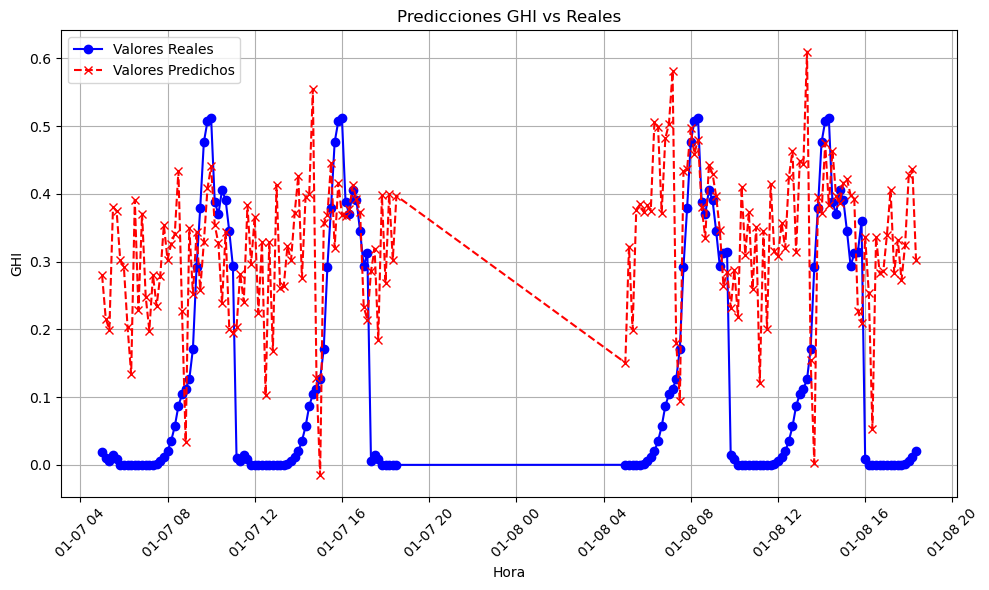

In [26]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime, timedelta
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Concatenate, Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# Función para convertir el formato de timestamp al nuevo formato de los nombres de las imágenes
def timestamp_to_image_name(timestamp, mode='M6'):
    # Convertir timestamp al formato con M6 o M4, ignorando los últimos dos segundos
    return f'OR_ABI-L2-ACMF-{mode}_G16_s' + timestamp.strftime('%Y%m%d%H%M')

# Función para buscar la imagen más cercana si no hay coincidencia exacta
def find_closest_image(timestamp, image_folder, modes=['M6', 'M4'], max_diff_minutes=10):
    # Crear un rango de posibles timestamps cercanos
    for delta in range(-max_diff_minutes, max_diff_minutes + 1):
        adjusted_timestamp = timestamp + timedelta(minutes=delta)
        for mode in modes:
            image_name_base = timestamp_to_image_name(adjusted_timestamp, mode)
            for filename in os.listdir(image_folder):
                if filename.startswith(image_name_base):  # Ignorar últimos dígitos
                    image_path = os.path.join(image_folder, filename)
                    print(f"Imagen encontrada: {image_path}")  # Agregar depuración
                    return image_path
    return None  # Si no se encuentra ninguna imagen

# Cargar imágenes y valores GHI normalizados, con imágenes redimensionadas
def load_images_and_ghi(df_filtrado, image_folder):
    images = []
    ghi_values = []
    
    # Listar los archivos de imágenes en el directorio una vez
    image_files = sorted(os.listdir(image_folder))
    
    for index, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        # Tratar de buscar una imagen cuyo nombre comience con el timestamp formateado
        found_image = False
        for mode in ['M6', 'M4']:
            image_path = find_closest_image(timestamp, image_folder, [mode])
            if image_path:
                # Cargar la imagen y agregarla a la lista
                image = cv2.imread(image_path)
                image = cv2.resize(image, (64, 64))  # Redimensionar a 64x64
                images.append(np.array(image))
                ghi_values.append(row['GHI'])
                found_image = True
                break
        
        if not found_image:
            print(f"Imagen no encontrada para el timestamp: {timestamp}, se omite el valor de GHI correspondiente.")
    
    if len(images) == 0:
        raise ValueError("No se encontraron imágenes para los timestamps proporcionados.")
    
    print(f"Total de imágenes encontradas: {len(images)}")
    
    # Verificar si hay suficientes datos para escalar
    if len(ghi_values) == 0:
        raise ValueError("No se encontraron suficientes valores de GHI para escalar.")
    
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)

    return np.array(images), ghi_values_scaled, scaler

# Crear secuencias de entrada y salida
def create_sequences(X_images, y_ghi, seq_len, num_pred):
    X_seq_images = []
    X_seq_ghi = []
    y_seq_ghi = []

    for i in range(len(X_images) - seq_len - num_pred):
        X_seq_images.append(X_images[i:i+seq_len])  # Secuencia de imágenes
        X_seq_ghi.append(y_ghi[i:i+seq_len])        # Secuencia de valores GHI
        y_seq_ghi.append(y_ghi[i+seq_len:i+seq_len+num_pred])  # Valores a predecir

    return np.array(X_seq_images), np.array(X_seq_ghi), np.array(y_seq_ghi)

# Función para graficar las predicciones junto con los valores reales
def plot_real_vs_predicted(timestamps, y_real, y_pred, title="Predicciones GHI vs Reales"):
    plt.figure(figsize=(10, 6))

    # Alinear las longitudes de y_real y y_pred con los timestamps
    min_len = min(len(timestamps), len(y_real.flatten()), len(y_pred.flatten()))

    # Graficar los valores reales
    plt.plot(timestamps[:min_len], y_real.flatten()[:min_len], label="Valores Reales", color='blue', marker='o')

    # Graficar los valores predichos
    plt.plot(timestamps[:min_len], y_pred.flatten()[:min_len], label="Valores Predichos", color='red', linestyle='--', marker='x')

    plt.title(title)
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Función para ajustar seq_len y num_pred en función del rango de tiempo
def calculate_seq_len_num_pred(start_date, end_date, data_frequency_minutes=10, min_seq_len=12, min_num_pred=5):
    delta = end_date - start_date
    delta_minutes = delta.total_seconds() / 60
    data_points = int(delta_minutes // data_frequency_minutes)
    seq_len = max(min_seq_len, data_points // 3)
    num_pred = max(min_num_pred, data_points // 6)
    return seq_len, num_pred

# Definir el modelo CNN-LSTM usando VGG16
def train_model_vgg16(X_images, y_ghi, seq_len, num_pred):
    X_images_seq, X_ghi_seq, y_ghi_pred = create_sequences(X_images, y_ghi, seq_len, num_pred)
    from sklearn.model_selection import train_test_split
    X_images_seq_train, X_images_seq_val, X_ghi_seq_train, X_ghi_seq_val, y_ghi_pred_train, y_ghi_pred_val = train_test_split(
        X_images_seq, X_ghi_seq, y_ghi_pred, test_size=0.2, random_state=42)

    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    vgg16_base.trainable = False

    image_input = Input(shape=(seq_len, 64, 64, 3))  
    vgg16_features = TimeDistributed(vgg16_base)(image_input)
    vgg16_features = TimeDistributed(Flatten())(vgg16_features)

    numeric_input = Input(shape=(seq_len, 1))
    concat = Concatenate()([vgg16_features, numeric_input])

    lstm_out = LSTM(64, return_sequences=False)(concat)
    lstm_out = Dropout(0.3)(lstm_out)

    output = Dense(num_pred)(lstm_out)

    model = Model([image_input, numeric_input], output)
    model.compile(optimizer='adam', loss='mse')

    history = model.fit([X_images_seq_train, X_ghi_seq_train], y_ghi_pred_train,
                        validation_data=([X_images_seq_val, X_ghi_seq_val], y_ghi_pred_val),
                        epochs=10, batch_size=32)

    return model, history

# --------------------------------------------------------------------------------------------

# Cargar el DataFrame
df = pd.read_pickle('df_GHI.plk')

# Definir el rango de fechas para el entrenamiento
fecha_inicio_entrenamiento = '2023-01-01 05:00:00'
fecha_fin_entrenamiento = '2023-01-06 18:20:00'

# Filtrar el DataFrame por el rango de entrenamiento
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_entrenamiento = df[(df['Timestamp'] >= fecha_inicio_entrenamiento) & (df['Timestamp'] <= fecha_fin_entrenamiento)]

# Cargar imágenes y valores GHI para el entrenamiento
image_folder = 'Images/enero'
X_images_train, y_ghi_train, scaler_train = load_images_and_ghi(df_entrenamiento, image_folder)

# Definir el rango de fechas para la predicción
fecha_inicio_prediccion = '2023-01-07 05:00:00'
fecha_fin_prediccion = '2023-01-08 18:20:00'

# Filtrar el DataFrame por el rango de predicción
df_prediccion = df[(df['Timestamp'] >= fecha_inicio_prediccion) & (df['Timestamp'] <= fecha_fin_prediccion)]

# Cargar imágenes y valores GHI para la predicción
X_images_test, y_ghi_test, scaler_test = load_images_and_ghi(df_prediccion, image_folder)

# Calcular automáticamente seq_len y num_pred en función del rango de fechas de predicción
start_date = pd.to_datetime(fecha_inicio_prediccion)
end_date = pd.to_datetime(fecha_fin_prediccion)
seq_len, num_pred = calculate_seq_len_num_pred(start_date, end_date)

# Verificar si hay suficientes datos para crear secuencias de entrenamiento
if len(X_images_train) > seq_len:
    model, history = train_model_vgg16(X_images_train, y_ghi_train, seq_len, num_pred)

    # Crear las secuencias de prueba para la predicción
    if len(X_images_test) > seq_len:
        X_images_seq_test, X_ghi_seq_test, y_ghi_pred_test = create_sequences(X_images_test, y_ghi_test, seq_len, num_pred)

        # Realizar predicciones
        y_pred = model.predict([X_images_seq_test, X_ghi_seq_test])

        # Desnormalizar los valores predichos
        y_pred_descaled = scaler_train.inverse_transform(y_pred)

        # Desnormalizar los valores reales para comparación
        y_real_descaled = scaler_train.inverse_transform(y_ghi_pred_test.reshape(-1, y_ghi_pred_test.shape[-1]))

        # Graficar los resultados
        timestamps_test = df_prediccion['Timestamp'].values[-len(y_real_descaled):]
        plot_real_vs_predicted(timestamps_test, y_real_descaled, y_pred_descaled)

    else:
        print("No hay suficientes imágenes en el conjunto de prueba para crear secuencias.")
else:
    print("No hay suficientes imágenes en el conjunto de entrenamiento para crear secuencias.")
